In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Initialize seed trip matrix
seed_matrix = np.array([
    [  5,  40, 120,  30,  50,  60],
    [ 40,   5,  52,  55,  60, 100],
    [120,  52,  10,  25,  90,  30],
    [ 30,  55,  25,  10,  15,  45],
    [ 50,  60,  90,  15,  15,  55],
    [ 60, 100,  30,  45,  55,  20]
])

# Initialize target productions/attractions
target_productions = np.array([800, 400, 400, 200,  500, 700])
target_attractions = np.array([200, 600, 400, 300, 1000, 500])

# Initial predicted productions and attractions
predicted_productions = seed_matrix.sum(axis=1)
predicted_attractions = seed_matrix.sum(axis=0)

# Create DataFrames for ease of readability
trip_matrix = pd.DataFrame(seed_matrix)

# Set row and column indices from 1 to 6
trip_matrix.index = range(1, 7)
trip_matrix.columns = range(1, 7)

# Define convergence criteria and max iterations
convergence_criteria = (0.90, 1.10)
max_iterations = 3

for iteration in range(1, max_iterations + 1):
    # Calculate row and column factors
    row_factors = target_productions / predicted_productions
    col_factors = target_attractions / predicted_attractions

    # Update the trip matrix with average factor adjustments
    for r in range(trip_matrix.shape[0]):
        for c in range(trip_matrix.shape[1]):
            avg_factor = (row_factors[r] + col_factors[c]) / 2
            trip_matrix.iloc[r, c] *= avg_factor

    # Prepare DataFrames for display with specified formatting

    trip_matrix_display = trip_matrix.round(1).copy().applymap(lambda x: f"{x:.1f}".rstrip('0').rstrip('.'))

    predicted_productions_df = pd.DataFrame({'Predicted Pi': predicted_productions}, index=trip_matrix.index).applymap(lambda x: f"{x:.1f}")

    predicted_attractions_df = pd.DataFrame([predicted_attractions], columns=trip_matrix.columns, index=['Predicted Aj']).applymap(lambda x: f"{x:.1f}")

    target_productions_df = pd.DataFrame(target_productions, index=trip_matrix.index, columns=['Target P']).applymap(lambda x: f"{x:.1f}")

    target_attractions_df = pd.DataFrame([target_attractions], columns=trip_matrix.columns, index=['Target A']).applymap(lambda x: f"{x:.1f}")

    row_factors_df = pd.DataFrame(row_factors, index=trip_matrix.index, columns=['Fi'])
    col_factors_df = pd.DataFrame(col_factors, index=trip_matrix.columns, columns=['Fj']).T


    # Combine all dataframes
    combined_display = pd.concat([trip_matrix_display, predicted_productions_df,target_productions_df, row_factors_df, ], axis=1)

    # Append the predicted and target attractions rows and column factors
    combined_display = pd.concat([combined_display, predicted_attractions_df, target_attractions_df, col_factors_df], axis=0)

    # Update predicted productions and attractions
    predicted_productions = trip_matrix.sum(axis=1).values
    predicted_attractions = trip_matrix.sum(axis=0).values

    # Check convergence
    row_factors_close = (convergence_criteria[0] <= row_factors) & (row_factors <= convergence_criteria[1])
    col_factors_close = (convergence_criteria[0] <= col_factors) & (col_factors <= convergence_criteria[1])

# Display final trip matrix rounded to the nearest whole number
final_trip_matrix = trip_matrix.round(0).applymap(lambda x: f"{x:.0f}")
final_trip_matrix

,1,2,3,4,5,6
1,7,105,216,72,219,144
2,23,7,45,69,161,125
3,65,70,8,30,232,36
4,16,73,20,12,38,52
5,47,121,118,27,54,100
6,68,228,46,93,214,41


In [ ]:
# Define the travel time matrix as a NumPy array
travel_time_matrix = np.array([
    [10, 25, 37, 40, 40, 50],
    [25, 10, 52, 35, 30, 40],
    [37, 52, 10, 55, 40, 50],
    [40, 35, 55, 10, 25, 37],
    [40, 30, 40, 25, 10, 25],
    [50, 40, 50, 37, 25, 10]
])

# Define the parameter beta
beta = -0.05

# Apply the exponential friction function to the travel time matrix
friction_matrix = np.exp(beta * travel_time_matrix)

# Convert the result to a DataFrame for better readability
friction_df = pd.DataFrame(friction_matrix, columns=[f'Zone {i+1}' for i in range(6)],
                            index=[f'Zone {i+1}' for i in range(6)])

# Display the friction matrix
print("Matrix of Basic Friction Values:")
friction_df

Matrix of Basic Friction Values:


,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5,Zone 6
Zone 1,0.606531,0.286505,0.157237,0.135335,0.135335,0.082085
Zone 2,0.286505,0.606531,0.074274,0.173774,0.223130,0.135335
Zone 3,0.157237,0.074274,0.606531,0.063928,0.135335,0.082085
Zone 4,0.135335,0.173774,0.063928,0.606531,0.286505,0.157237
Zone 5,0.135335,0.223130,0.135335,0.286505,0.606531,0.286505
Zone 6,0.082085,0.135335,0.082085,0.157237,0.286505,0.606531


In [ ]:
# Average travel time

# Step 1: Multiply the two matrices
# (Use .values on final_trip_matrix (dF), but access travel_time_matrix directly (NumPy array))
weighted_travel_times = travel_time_matrix * final_trip_matrix.astype(float).values

# Step 2: Sum the results to get the total weighted travel time
total_weighted_travel_time = weighted_travel_times.sum()

# Step 3: Sum the values in final_trip_matrix to get total trips
total_trips = final_trip_matrix.astype(float).values.sum()

# Step 4: Calculate the average weighted travel time
average_weighted_travel_time = total_weighted_travel_time / total_trips

print(f"Average Weighted Travel Time: {average_weighted_travel_time:.2f} minutes.")

Average Weighted Travel Time: 36.26 minutes.


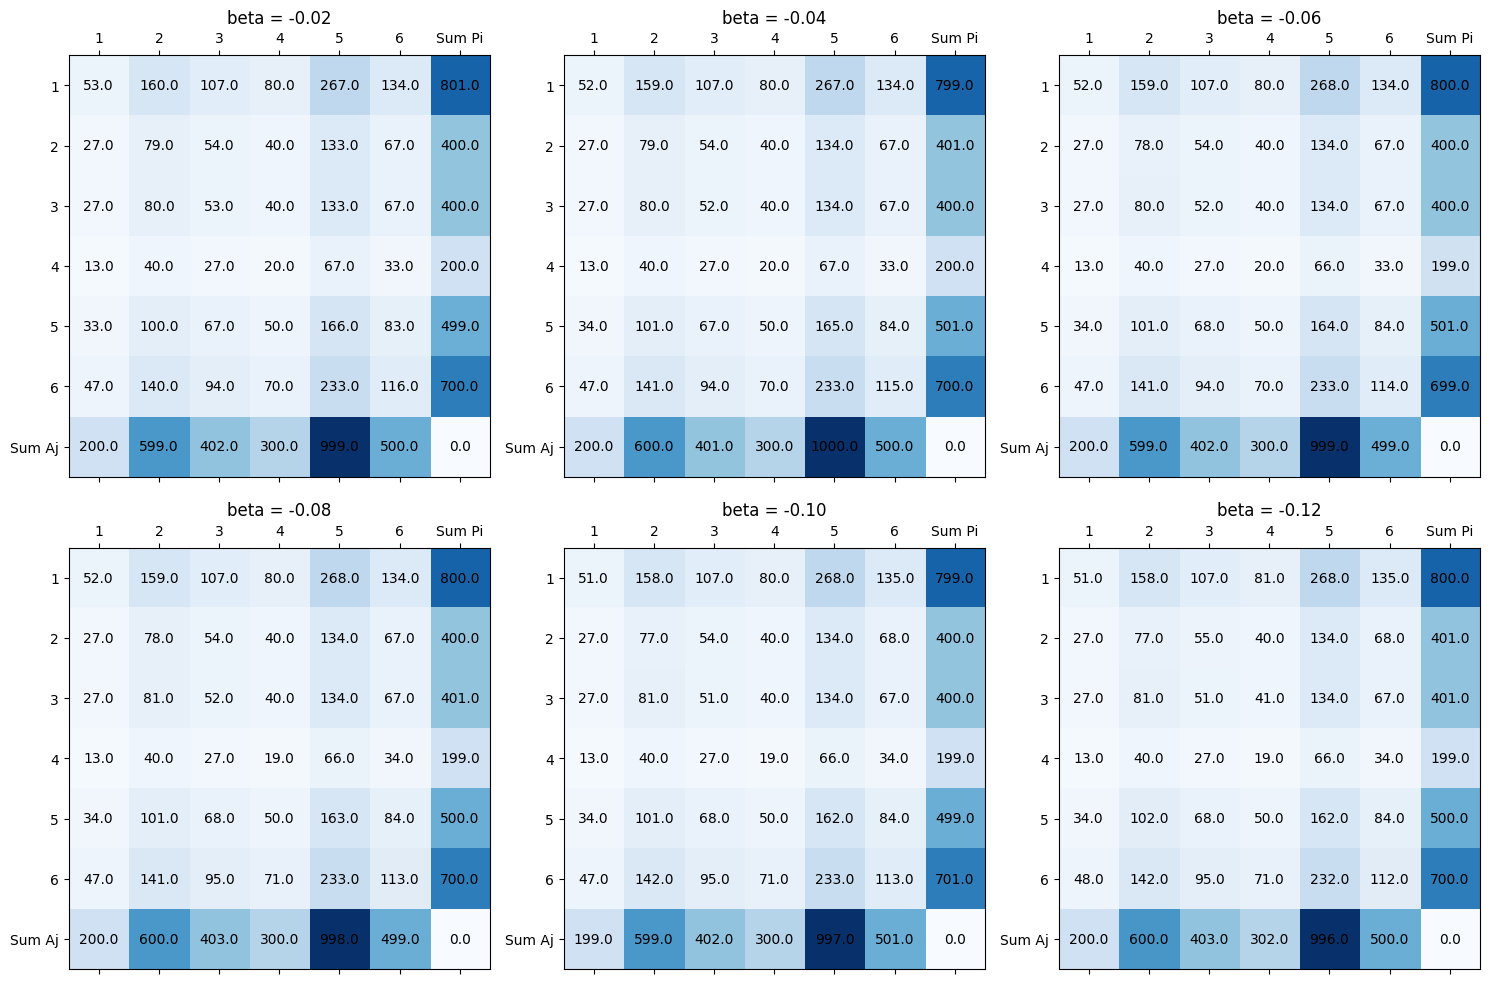

In [ ]:
# Define beta values
beta_values = np.arange(-0.02, -0.13, -0.02)

# Initialize a dictionary to store results for each beta
gravity_model_results = {}

# Iterate over each beta value
for beta in beta_values:
    trips = np.zeros((len(target_productions), len(target_attractions)))

    for i in range(len(target_productions)):
        for j in range(len(target_attractions)):
            # Calculate the denominator for the gravity model formula
            denominator = sum(target_attractions[j] * np.exp(beta * friction_df.iloc[i, j]) for j in range(len(target_attractions)))

            # Apply the gravity model formula to calculate T_ij
            trips[i, j] = (target_productions[i] * target_attractions[j] * np.exp(beta * friction_df.iloc[i, j])) / denominator

    # Add row sums and column sums
    trips = np.rint(trips)  # Round each element to the nearest integer
    trips = np.vstack([trips, trips.sum(axis=0)])  # Append column sums
    trips = np.column_stack([trips, trips.sum(axis=1)])  # Append row sums

    # Remove the bottom-right cell value
    trips[-1, -1] = np.nan

    # Store the results in the dictionary for each beta
    gravity_model_results[beta] = trips

# Arrange matrices in a grid layout
n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for idx, (beta, trips) in enumerate(gravity_model_results.items()):
    ax = axes[idx // n_cols, idx % n_cols]

    # Convert trips to a DataFrame and replace NaN with 0 for matshow
    trips_display = pd.DataFrame(
        trips,
        index=[*range(1, len(target_productions) + 1), "Sum Aj"],
        columns=[*range(1, len(target_attractions) + 1), "Sum Pi"]
    ).fillna(0).astype(float)  # Replace NaN with 0 and convert to float

    ax.matshow(trips_display, cmap="Blues")
    ax.set_title(f"beta = {beta:.2f}")
    ax.set_xticks(range(trips_display.shape[1]))
    ax.set_yticks(range(trips_display.shape[0]))
    ax.set_xticklabels(trips_display.columns)
    ax.set_yticklabels(trips_display.index)
    # Display values in cells
    for (i, j), val in np.ndenumerate(trips_display.values):
        ax.text(j, i, f"{val}", ha="center", va="center")

plt.tight_layout()
plt.show()

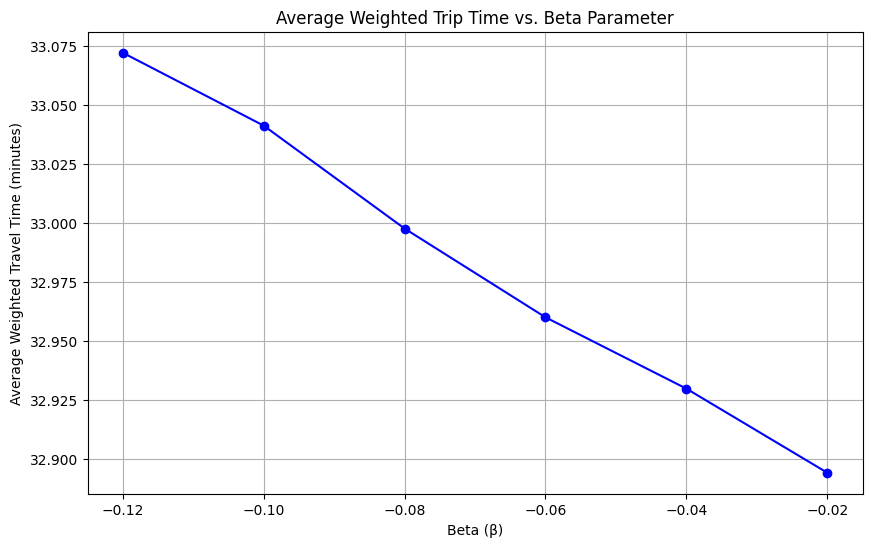

In [ ]:
# Initialize a list to store average weighted travel times
average_trip_times = []

# Iterate over each beta value and calculate the average weighted travel time
for beta, trips in gravity_model_results.items():
    # Extract the main trip matrix (excluding sums)
    main_trips = trips[:-1, :-1]  # Select all rows except the last, all columns except the last

    # Step 1: Multiply the two matrices
    weighted_travel_times = travel_time_matrix * main_trips.astype(float)

    # Step 2: Sum the results to get the total weighted travel time
    total_weighted_travel_time = weighted_travel_times.sum()

    # Step 3: Sum the values in main_trips to get total trips
    total_trips = main_trips.sum()

    # Step 4: Calculate the average weighted travel time
    average_trip_time = total_weighted_travel_time / total_trips if total_trips > 0 else 0

    # Store the result for the current beta value
    average_trip_times.append(average_trip_time)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(beta_values, average_trip_times, marker='o',color='b')
plt.title('Average Weighted Trip Time vs. Beta Parameter')
plt.xlabel('Beta (β)')
plt.ylabel('Average Weighted Travel Time (minutes)')
plt.xticks(beta_values)
plt.grid()
plt.show()